In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

!pip install -U openpyxl
!pip install evaluate
!pip install --upgrade transformers

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# file_path = "/content/drive/My Drive/606_PROJECT/Final_Combined_News_Data.csv"
file_path = "/content/drive/My Drive/606_PROJECT/balanced_dataset_30k.csv"

In [4]:
import pandas as pd

df = pd.read_csv(file_path)
df.head()


,title,text,date,label,is_scraped
0,Democrats lodge complaint against acting deput...,Senate Democrats are urging New York legal aut...,2025-03-04T20:47:53Z,1,1
1,Racist Conservatives Wish Sasha Obama A Happy ...,Friday was Sasha Obama s 15th birthday. All ar...,"June 10, 2016",0,0
2,Trump Emboldens Ohio Republicans To Ban Aborti...,Donald Trump has not even taken office yet and...,"December 7, 2016",0,0
3,NASA confirms presence of arm on the moon.,NASA confirms presence of arm on the moon. Sid...,2023-06-20,0,0
4,Clinton hits Trump over comments on women ahea...,"HAVERFORD, Pa. (Reuters) - Democrat Hillary Cl...",5-Oct-16,1,0


In [5]:
df.isnull().sum()
df = df.dropna()

df.isnull().sum()

,0
title,0
text,0
date,0
label,0
is_scraped,0


In [6]:
df.shape

(29999, 5)

In [7]:
df['label'].value_counts()

,count
label,
0,15000
1,14999


In [8]:
import matplotlib.pyplot as plt

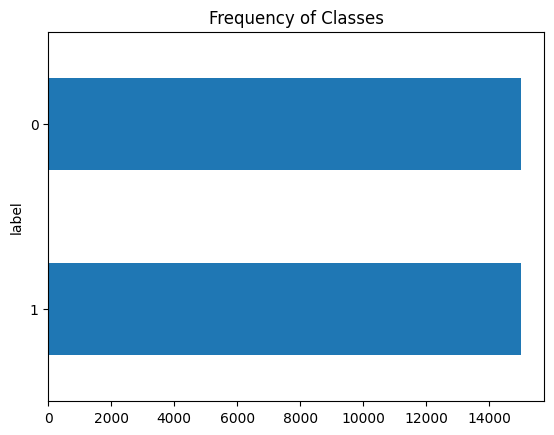

In [9]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

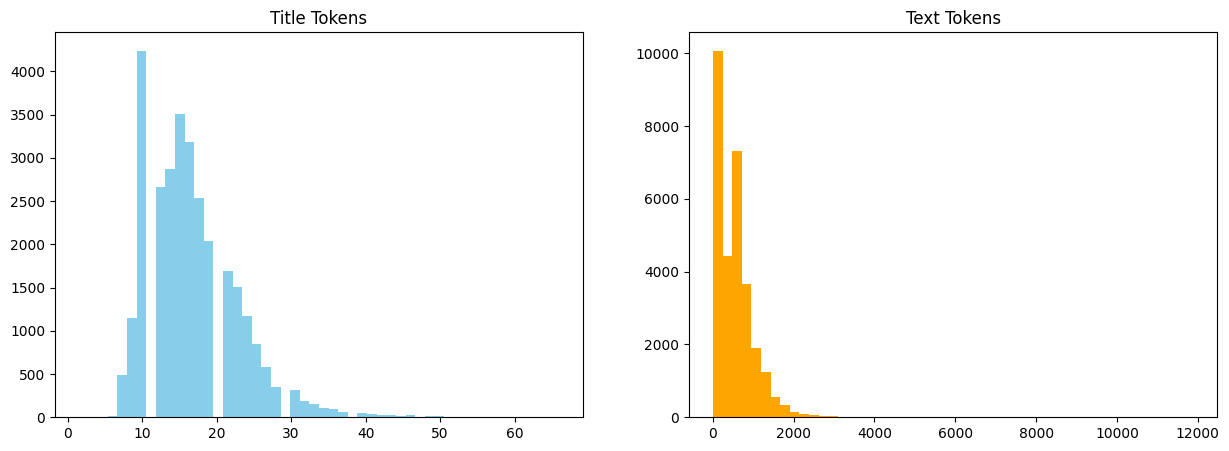

In [10]:
# 1.5 tokens per word on average
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)


fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

In [11]:
from sklearn.model_selection import train_test_split

# 70% for training, 20% test, 10% validation
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape



((20999, 7), (6000, 7), (3000, 7), (29999, 7))

In [12]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'date', 'label', 'is_scraped', 'title_tokens', 'text_tokens'],
        num_rows: 20999
    })
    test: Dataset({
        features: ['title', 'text', 'date', 'label', 'is_scraped', 'title_tokens', 'text_tokens'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['title', 'text', 'date', 'label', 'is_scraped', 'title_tokens', 'text_tokens'],
        num_rows: 3000
    })
})

In [13]:
from transformers import AutoTokenizer

text = "Fake News Detection Using BERT Model"

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [14]:
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=100

In [15]:
def tokenize(batch):
    temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

In [16]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/20999 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [17]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 1, "Fake": 0}
id2label = {1:"Real", 0:"Fake"}

model_ckpt = "distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"


num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)




Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Fake",
    "1": "Real"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 0,
    "Real": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "vocab_size": 30522
}

In [19]:
# Build compute metrics function
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [20]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
                                  output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  report_to="none",
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  # evaluation_strategy ='epoch'
)



In [21]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=distilbert_tokenizer
)

In [22]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saitejb3 (saitejb3-umbc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.245000


Step,Training Loss
500,0.245000
1000,0.157100
1500,0.143200
2000,0.114500
2500,0.107300
3000,0.074500
3500,0.048000
4000,0.039700
4500,0.054200
5000,0.055100


TrainOutput(global_step=7875, training_loss=0.07133057167416527, metrics={'train_runtime': 408.0872, 'train_samples_per_second': 154.371, 'train_steps_per_second': 19.297, 'total_flos': 929038626266652.0, 'train_loss': 0.07133057167416527, 'epoch': 3.0})

In [23]:
preds_output = trainer.predict(encoded_dataset['test'])


In [24]:
preds_output.metrics

{'test_loss': 0.14231102168560028,
 'test_accuracy': 0.9753333333333334,
 'test_runtime': 5.2041,
 'test_samples_per_second': 1152.933,
 'test_steps_per_second': 144.117}

In [25]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test'][:]['label']

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.97      0.98      0.98      3000
        Fake       0.98      0.97      0.98      3000

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



In [27]:
trainer.save_model("fake_news")

In [28]:
from transformers import pipeline

news_classifier = pipeline('text-classification', model= 'fake_news')


Device set to use cuda:0


In [29]:
news_classifier("some text data")

[{'label': 'Real', 'score': 0.9998956918716431}]

In [30]:
news_classifier("Trump administration to halt new research grants for Harvard as battle over political ideology and academic freedom flares")

[{'label': 'Real', 'score': 0.9979209303855896}]

In [31]:
news_classifier("fake news")

[{'label': 'Fake', 'score': 0.9999741315841675}]

In [32]:
news_classifier("trump died in usa white house")

[{'label': 'Real', 'score': 0.9997665286064148}]

In [33]:
news_classifier("india got terror attack last night")

[{'label': 'Real', 'score': 0.9999551773071289}]

In [34]:
news_classifier("Government Replaces All Currency with Digital Coin Without Public Vote")

[{'label': 'Real', 'score': 0.9987804293632507}]

In [35]:
news_classifier("Government Replaces All Currency with Digital Coin Without Public Vote")

[{'label': 'Real', 'score': 0.9987804293632507}]

In [36]:
news_classifier("Elections Cancelled: Martial Law Declared Over Tax Reform Protests")

[{'label': 'Real', 'score': 0.9999566078186035}]

In [53]:
news_classifier("The car bombing outside a California fertility clinic that killed one person and injured four others appears to have been driven by anti-natalist ideology, according to two senior law enforcement officials briefed on the incident.")

[{'label': 'Fake', 'score': 0.9999947547912598}]

In [51]:
news_classifier("Time Traveler Arrested at Large Hadron Collider for Predicting 2025 Events")

[{'label': 'Real', 'score': 0.999976396560669}]

In [54]:
# Save just the weights
torch.save(model.state_dict(), "fakenews_bert_weights_v1_updated.pt")
